In [1]:
# Task B2
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import os

C:\Users\THO NGUYEN\AppData\Local\Temp\ipykernel_20620\1747604047.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Task B2
TICKER = "AAPL"
START_DATE = "2014-01-01"
END_DATE = "2020-12-31"
LOOK_UP_DAYS = 30    
TRAINING_RATIO = 0.7    # 0.7 == 70%
SCALE_DATA = True
SCALING_METHOD = "MinMax"       # MinMax, Standard

In [3]:
def DataScaler(stock_data, scaling_method=SCALING_METHOD):

    DatasetScaler = None
    ColumnScalers = {

    }
    if scaling_method == "MinMax":
        DatasetScaler = preprocessing.MinMaxScaler()
        
    
    elif scaling_method == "Standard":
        DatasetScaler = preprocessing.StandardScaler()

    
    # Learn the whole dataset
    col_names = stock_data.columns
    features = stock_data[col_names]
    DatasetScaler.fit(features.values)
    features = DatasetScaler.transform(features.values)
    scaledDataFrame = pd.DataFrame(features, columns = col_names)
    scaledDataFrame.index = stock_data.index
    
    for column in col_names:
        column_scaler = None
        if scaling_method == "MinMax":
            column_scaler = preprocessing.MinMaxScaler()
        elif scaling_method == "Standard":
            column_scaler = preprocessing.StandardScaler()
        column_scaler.fit(stock_data[column].values.reshape(-1,1))
        ColumnScalers[column] = column_scaler

    return scaledDataFrame, DatasetScaler, ColumnScalers

In [4]:
def DataLoader(ticker=TICKER, start_date=START_DATE, end_date=END_DATE, scale=SCALE_DATA, scaling_method=SCALING_METHOD):
    '''
    ticker: is the code of the target ticker
    start_date: a start date string with format YYYY/MM/DD
    end_date: an end date string with format YYYY/MM/DD
    scale: a boolean value, True by default
    scaling_method: MinMax(by default), Standard.
    '''

    # result
    result = {
        "dataset": None,
        "datasetScaler": None,
        "columnScalers": None
    }

    # processing the input parameters
    start_date = dt.datetime.strptime(start_date, "%Y-%m-%d")
    end_date = dt.datetime.strptime(end_date, "%Y-%m-%d")


    # creating necessary folder
    if not os.path.isdir("results"):
        os.mkdir("results")
    
    if not os.path.isdir("data"):
        os.mkdir("data")


    
    # checking if the data is already downloaded 
    ## Get a list of files in the directory
    files = os.listdir("data")
    ## Check each file in the directory
    data = None
    for file_name in files:
        ## if we already downloaded the ticket data
        if file_name.startswith(ticker) and file_name.endswith(".csv"):
            ### Read the file 
            file_path = os.path.join("data", f"{ticker}.csv")
            data = pd.read_csv(file_path, parse_dates=['Date'])
            break

    ## else, we gonna download the stock data
    if data is None:
        stock_data = yf.download(ticker, start_date, end_date)
        file_path = os.path.join("data", f"{ticker}.csv")
        stock_data.to_csv(file_path)
        data = pd.read_csv(file_path, parse_dates=['Date'])

    # if the given time is included in the file, we just take the nessecary dataframe
    if data.head(1)["Date"].values[0] <= np.datetime64(start_date) and data.tail(1)["Date"].values[0] >= np.datetime64(end_date):
        data = data[(data['Date'] >= pd.to_datetime(start_date)) & (data['Date'] <= pd.to_datetime(end_date))]
        
    else: 
        stock_data = yf.download(ticker, start_date, end_date)
        file_path = os.path.join("data", f"{ticker}.csv")
        stock_data.to_csv(file_path)
        data = pd.read_csv(file_path, parse_dates=['Date'])
        

    # Setting Date as Index
    data.set_index('Date', inplace=True)

    # Scale Data
    if scale:
        data, scaler, column_scalers = DataScaler(data, scaling_method)
        result["dataset"] = data
        result["datasetScaler"] = scaler
        result["columnScalers"] = column_scalers
        return result

    result["dataset"] = data
    
    return result

In [5]:
def datasetSplitter(dataset: pd.DataFrame, look_up_days=LOOK_UP_DAYS, 
        training_ratio=TRAINING_RATIO,  
        feature_columns=['Open','High','Low','Close','Adj Close','Volume']):
    '''
    dataset: a Pandas Dataframe
    training_ratio: is equal to TRAINING_RATION constant
    '''
    # result
    splitResult = {
        "X_training_set": {
                        'Open': None,
                        'High': None,
                        'Low': None,
                        'Close': None,
                        'Adj Close': None,
                        'Volume': None
                        },
        "Y_training_set": {
                        'Open': None,
                        'High': None,
                        'Low': None,
                        'Close': None,
                        'Adj Close': None,
                        'Volume': None
                        },
        "X_testing_set": {
                        'Open': None,
                        'High': None,
                        'Low': None,
                        'Close': None,
                        'Adj Close': None,
                        'Volume': None
                        },
        "Y_testing_set": {
                        'Open': None,
                        'High': None,
                        'Low': None,
                        'Close': None,
                        'Adj Close': None,
                        'Volume': None
                        }
    }
  
    for column in feature_columns:
        dataset_in_column = dataset[column].values.reshape(-1, 1)      # <class 'numpy.ndarray'>
        x_data = []
        y_data = []
    
        for x in range(look_up_days, len(dataset_in_column)):
            x_data.append(dataset_in_column[x - look_up_days:x, 0])
            y_data.append(dataset_in_column[x, 0])

        splitResult["X_training_set"][column], splitResult["X_testing_set"][column], splitResult["Y_training_set"][column], splitResult['Y_testing_set'][column] = train_test_split(x_data, y_data, test_size=1-training_ratio, shuffle=False)

        ## Converting to numpy.array

        for column in feature_columns:
            splitResult["X_training_set"][column] = np.array(splitResult["X_training_set"][column])
            splitResult["Y_training_set"][column] = np.array(splitResult["Y_training_set"][column])
            splitResult["X_testing_set"][column] = np.array(splitResult["X_testing_set"][column])
            splitResult["Y_testing_set"][column] = np.array(splitResult["Y_testing_set"][column])

    return splitResult

In [6]:
def Data_Processing_1():
    dataLoader = DataLoader()

    scaledStockData = dataLoader["dataset"]
    datasetScaler = dataLoader["datasetScaler"]
    columnScalers = dataLoader["columnScalers"]
    
    dataset = datasetSplitter(dataset=scaledStockData)
    
    
    return dataset, scaledStockData, datasetScaler, columnScalers
    

In [7]:
dataset, scaledStockData, datasetScaler, ColumnScalers  = Data_Processing_1()

# Defining RNNs

In [9]:
def create_RNN(hidden_units, dense_units, activation):
    model = Sequential()
    # model.add(SimpleRNN(hidden_units, activation=activation[0], return_sequences=True))
    model.add(SimpleRNN(hidden_units, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

demo_model = create_RNN(80, 1, activation=['tanh', 'linear'])

## Preprocessing Training Data

In [10]:
x_open_train = np.reshape(dataset["X_training_set"]["Open"], (dataset["X_training_set"]["Open"].shape[0], dataset["X_training_set"]["Open"].shape[1], 1))
y_open_train = dataset["Y_training_set"]["Open"]

print(x_open_train.shape)
print(y_open_train.shape)

(1213, 30, 1)
(1213,)


## Training 

In [11]:
history = demo_model.fit(x_open_train, y_open_train, epochs=25, batch_size=12, validation_split=0.2)

Epoch 1/25

81/81 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 5.8287e-04
Epoch 2/25
81/81 [==============================] - 0s 4ms/step - loss: 1.0533e-04 - val_loss: 2.9096e-04
Epoch 3/25
81/81 [==============================] - 0s 4ms/step - loss: 7.0312e-05 - val_loss: 2.5421e-04
Epoch 4/25
81/81 [==============================] - 0s 4ms/step - loss: 5.4916e-05 - val_loss: 2.0424e-04
Epoch 5/25
81/81 [==============================] - 0s 4ms/step - loss: 6.7536e-05 - val_loss: 1.6556e-04
Epoch 6/25
81/81 [==============================] - 0s 4ms/step - loss: 4.8277e-05 - val_loss: 1.6149e-04
Epoch 7/25
81/81 [==============================] - 0s 4ms/step - loss: 4.6455e-05 - val_loss: 2.0718e-04
Epoch 8/25
81/81 [==============================] - 0s 5ms/step - loss: 4.1012e-05 - val_loss: 1.3334e-04
Epoch 9/25
81/81 [==============================] - 0s 4ms/step - loss: 3.6273e-05 - val_loss: 1.7288e-04
Epoch 10/25
81/81 [==============================

## Predict

In [12]:
x_open_test = np.reshape(dataset["X_testing_set"]["Open"], (dataset["X_testing_set"]["Open"].shape[0], dataset["X_testing_set"]["Open"].shape[1], 1))
scaled_predicted_prices = demo_model.predict(x_open_test)
scaled_actual_prices = dataset["Y_testing_set"]["Open"]

17/17 [==============================] - 0s 2ms/step


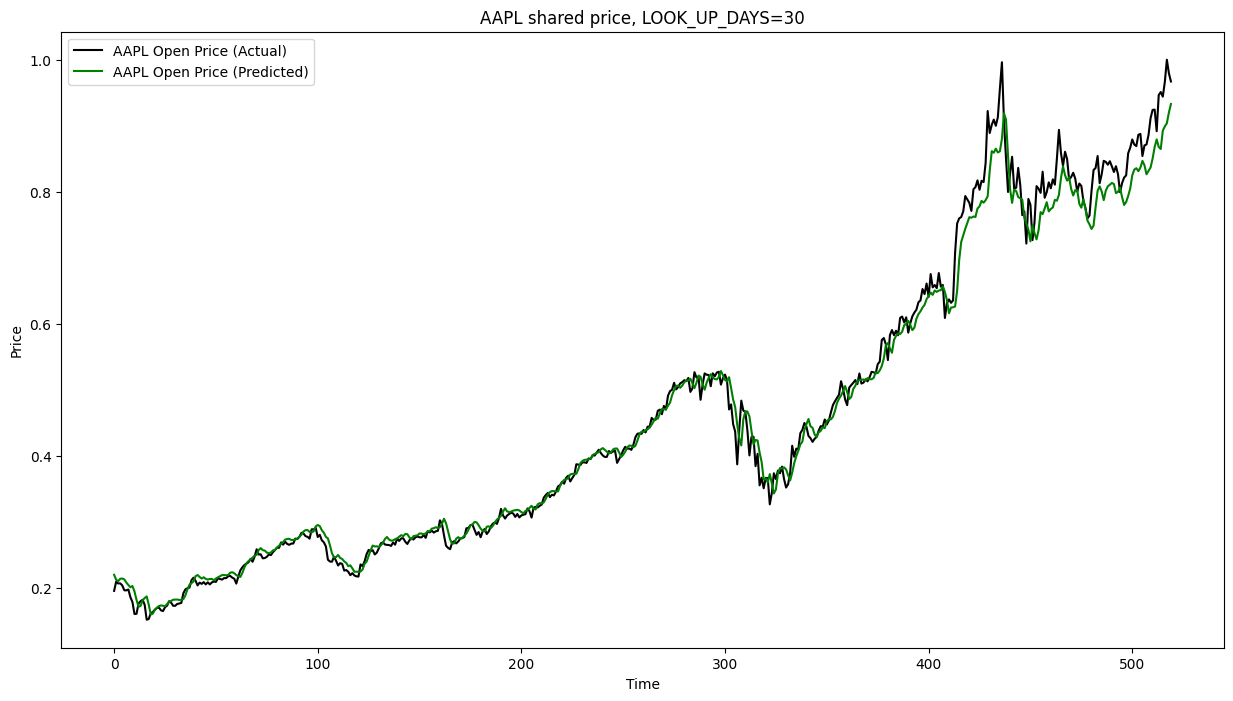

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8)) 
plt.plot(scaled_actual_prices, c="black", label = f"{TICKER} Open Price (Actual)")
plt.plot(scaled_predicted_prices, c="green", label = f"{TICKER} Open Price (Predicted)")
plt.legend()
plt.title(f"{TICKER} shared price, LOOK_UP_DAYS={LOOK_UP_DAYS}")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

## Rescaled

In [14]:
def columnInverser(columnData, ColumnScaler):
    '''columnData: an np.array'''
    # transform the shape of the data
    reshaped_data = columnData.reshape(-1, 1)
    result = ColumnScaler.inverse_transform(reshaped_data)
    return result

In [15]:
original_predicted_prices = columnInverser(scaled_predicted_prices, ColumnScalers["Open"])
original_actual_prices = columnInverser(scaled_actual_prices, ColumnScalers["Open"])

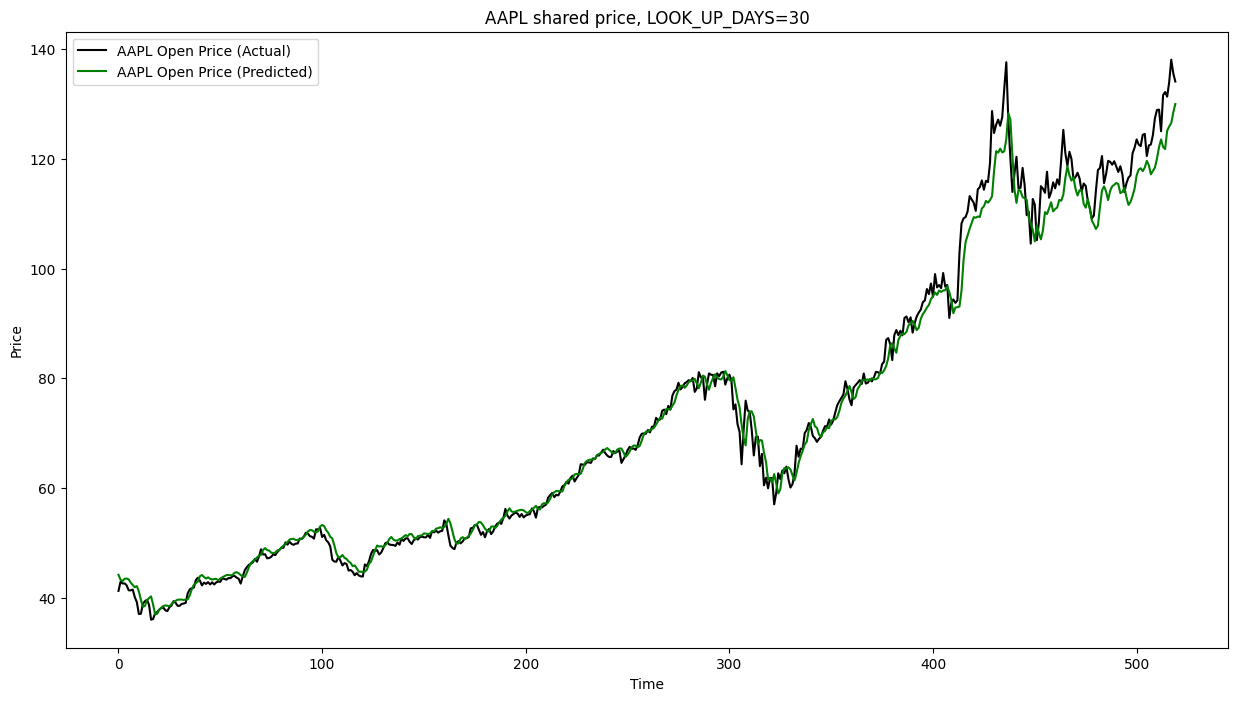

In [16]:
plt.figure(figsize=(15, 8)) 
plt.plot(original_actual_prices, c="black", label = f"{TICKER} Open Price (Actual)")
plt.plot(original_predicted_prices, c="green", label = f"{TICKER} Open Price (Predicted)")
plt.legend()
plt.title(f"{TICKER} shared price, LOOK_UP_DAYS={LOOK_UP_DAYS}")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

In [17]:
demo_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 80)                6560      
                                                                 
 dense (Dense)               (None, 1)                 81        
                                                                 
Total params: 6641 (25.94 KB)
Trainable params: 6641 (25.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


dict_keys(['loss', 'val_loss'])


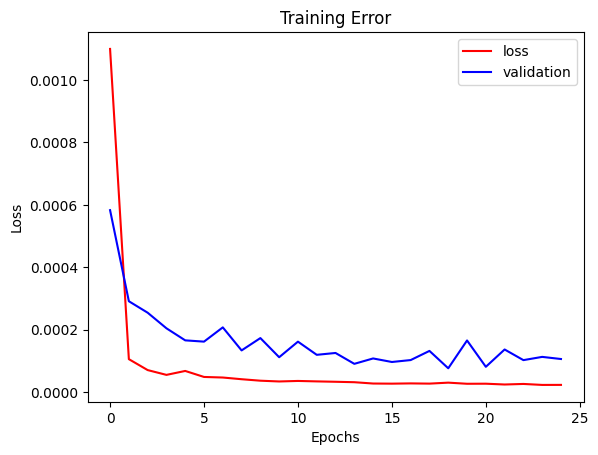

In [19]:
print(history.history.keys())

# plt.figure(figsize=(15, 8)) 
plt.plot(history.history['loss'], c="red", label = "loss")
plt.plot(history.history['val_loss'], c="blue", label = "validation")
plt.legend()
plt.title("Training Error")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()